<a href="https://colab.research.google.com/github/WakwUp1125/DKU_OPENSOURCE_1/blob/main/Demo_RetinaNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection using RetinaNet

RetinaNet is a neural network architecture for object detection described in [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002) by Tsung-Yi Lin, Priya Goyal, Ross Girshick, Kaiming He and Piotr Dollár.

The following shows how to use a [Keras based implementation](https://github.com/fizyr/keras-retinanet) along with model parameters pretrained on the [COCO object detection dataset](http://cocodataset.org/).

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%pip install -q keras-retinanet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


## Loading a Pretrained Keras Model

In [4]:
from urllib.request import urlretrieve
import os

PRETRAINED_MODEL_NAME = "resnet50_coco_best_v2.1.0.h5"
BACKBONE_NAME = 'resnet50'
PRETRAINED_BASE_URL = (
    "https://github.com/fizyr/keras-retinanet/"
    "releases/download/0.5.1/")

if not os.path.exists(PRETRAINED_MODEL_NAME):
    model_url = PRETRAINED_BASE_URL + PRETRAINED_MODEL_NAME
    print(f"Downloading {model_url}...")
    urlretrieve(model_url, PRETRAINED_MODEL_NAME)
    print("done.")

done.


In [5]:
ls -lh *.h5

-rw-r--r-- 1 root root 146M Dec 21 16:04 resnet50_coco_best_v2.1.0.h5


In [6]:
from keras_retinanet import models

# load retinanet model
model = models.load_model(PRETRAINED_MODEL_NAME, backbone_name=BACKBONE_NAME)

In [7]:
# print(model.summary())

## Detecting Objects (Location and Classes) in Test Images

We need to define a label to names mapping for visualization purposes: those labels match the classes from the COCO dataset:

In [8]:
labels_to_names = {
    0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane',
    5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light',
    10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench',
    14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow',
    20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack',
    25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee',
    30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite',
    34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard',
    37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass',
    41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl',
    46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli',
    51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake',
    56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed',
    60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse',
    65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave',
    69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book',
    74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear',
    78: 'hair drier', 79: 'toothbrush'}

In [9]:
!wget https://djl.ai/examples/src/test/resources/dog_bike_car.jpg ./dog_bike_car.jpg

--2023-12-21 16:05:05--  https://djl.ai/examples/src/test/resources/dog_bike_car.jpg
Resolving djl.ai (djl.ai)... 185.199.108.153, 185.199.111.153, 185.199.109.153, ...
Connecting to djl.ai (djl.ai)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163759 (160K) [image/jpeg]
Saving to: ‘dog_bike_car.jpg’

dog_bike_car.jpg    100%[===================>] 159.92K  --.-KB/s    in 0.01s   

2023-12-21 16:05:06 (11.8 MB/s) - ‘dog_bike_car.jpg’ saved [163759/163759]

--2023-12-21 16:05:06--  http://./dog_bike_car.jpg
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2023-12-21 16:05:06--
Total wall clock time: 0.4s
Downloaded: 1 files, 160K in 0.01s (11.8 MB/s)


shape: (800, 1067, 3), dtype: float32, range: (-123.4996, 255)
processing time: 5.4s
bicycle 0.848
dog 0.499
truck 0.483
car 0.470


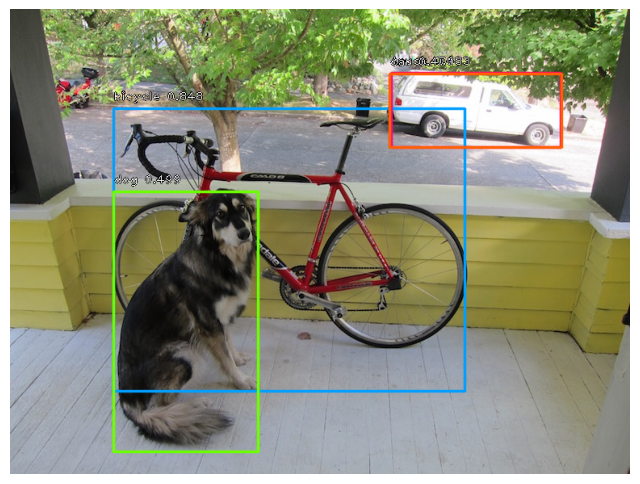

In [19]:
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
import matplotlib.pyplot as plt
import time
import cv2
import numpy as np


def detect_and_visualize(image_bgr):
    # copy to draw on
    draw = image_bgr.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image_input = image_bgr.copy()
    image_input = preprocess_image(image_input)
    image_input, scale = resize_image(image_input)
    print(f"shape: {image_input.shape}, dtype: {image_input.dtype}, "
          f"range: {(image_input.min(), image.max())}")

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(
        np.expand_dims(image_input, axis=0))
    print(f"processing time: {time.time() - start:.1f}s")

    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < 0.4:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        print(caption)
        draw_caption(draw, b, caption)

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(draw)


# load image
image = read_image_bgr('dog_bike_car.jpg')
detect_and_visualize(image)

shape: (800, 800, 3), dtype: float32, range: (-87.829994, 255)
processing time: 6.4s


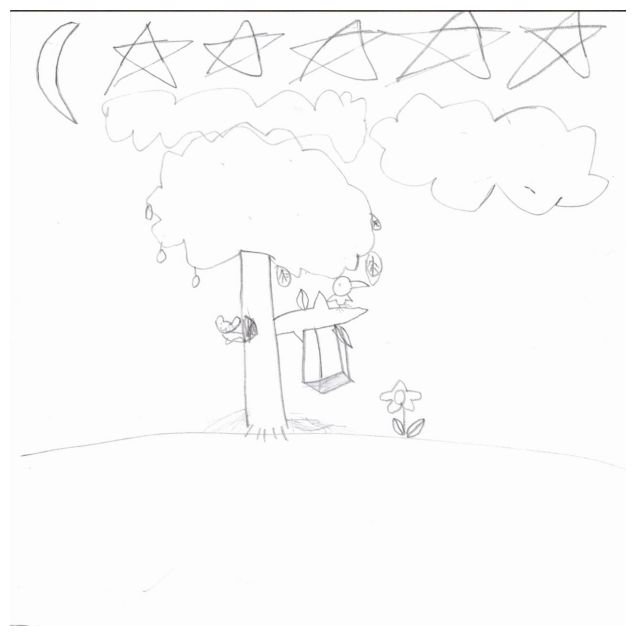

In [21]:
# load image
image = read_image_bgr('/content/drive/MyDrive/오픈소스Ai/나무_7_남_00242.jpg')
detect_and_visualize(image)